# Parallel llm workflow

In [12]:
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing import TypedDict, Annotated
import operator

In [2]:
# Load env variables
load_dotenv()

True

In [ ]:
# define model for llm output
class modelOut(BaseModel):
    score: int = Field(description="Score output from the model", gt=0, le=10)
    feedback: str = Field(description="Detailed feedback for the input text", max_length=200)


In [ ]:
# Create structured output model
model = ChatOpenAI(model="gpt-5-nano")
structured_model = model.with_structured_output(modelOut, strict=True)

In [ ]:
# state for workflow
class UPSCstate(TypedDict):
    essay: str
    language_quality_feedback: str
    essay_completeness_feedback: str
    raw_scores: Annotated[list[float], operator.add]
    feedback_summary: str
    overall_score: float

In [15]:
def evaluate_language_quality(state: UPSCstate):
    essay = state['essay']
    prompt = f"""
        Evaluate the following essay for language quality. Provide a feedback on grammar, vocabulary, sentence structure, and
        coherence. Score the language quality on a scale of 1 to 10. \n {essay}
    """
    result = structured_model.invoke(prompt)
    return {
        "language_quality_feedback": result.feedback,
        "raw_scores": [result.score]
    }


In [19]:
def evaluate_essay_completeness(state: UPSCstate):
    essay = state["essay"]
    prompt = f"""
        Evaluate the following essay for completeness. Provide a feedback on how well the essay covers all required points and arguments
        . Score the language quality on a scale of 1 to 10. \n {essay}
    """
    result = structured_model.invoke(prompt)
    return {"essay_completeness_feedback": result.feedback, "raw_scores": [result.score]}

In [22]:
def final_evaluator(state: UPSCstate):
    prompt = f"""
        Based on the following language quality feedback and essay completeness feedback,
        generate a feedback summary.
        Language quality feedback - {state["language_quality_feedback"]}
        Completeness feedback - {state["essay_completeness_feedback"]}
    """
    result = model.invoke(prompt)
    return {
        "feedback_summary": result.content,
        "overall_score": sum(state["raw_scores"]) / len(state["raw_scores"]),
    }

In [23]:
graph = StateGraph(UPSCstate)

graph.add_node("evaluate_language_quality", evaluate_language_quality)
graph.add_node("evaluate_essay_completeness", evaluate_essay_completeness)
graph.add_node("final_evaluator", final_evaluator)

graph.add_edge(START, "evaluate_language_quality")
graph.add_edge(START, "evaluate_essay_completeness")

graph.add_edge("evaluate_language_quality", "final_evaluator")
graph.add_edge("evaluate_essay_completeness", "final_evaluator")

graph.add_edge("final_evaluator", END)

workflow = graph.compile()

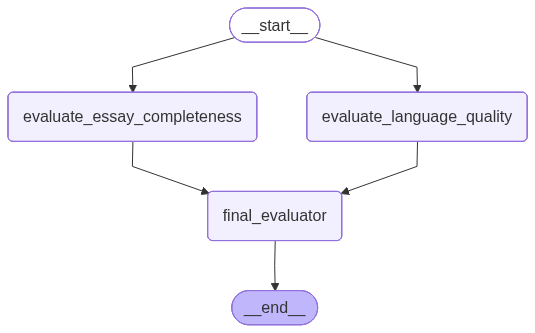

In [ ]:
# visualize workflow
workflow

In [25]:
initial_state = {
    "essay": "The impact of climate change on global ecosystems is profound and multifaceted. Rising temperatures, shifting weather patterns, and increased frequency of extreme weather events are altering habitats and threatening biodiversity. Species are being forced to migrate to new areas, often leading to conflicts with human populations"
}

In [26]:
result = workflow.invoke(initial_state)

In [28]:
print(result['essay_completeness_feedback'])

Overall, the paragraph establishes a central claim about the profound impact of climate change on global ecosystems and mentions several effects (temperature rise, shifting patterns, more extreme with


In [29]:
print(result['language_quality_feedback'])

Strengths: clear, formal tone; strong vocabulary (e.g., profound, multifaceted, altering, threatening). The paragraph presents a coherent progression from the impact on ecosystems to consequences for,


In [30]:
print(result['raw_scores'])
print(result['overall_score'])

[6, 8]
7.0


In [31]:
print(result['feedback_summary'])

Feedback Summary

- Overall impression:
  - The paragraph convincingly argues that climate change has a profound impact on global ecosystems and references multiple effects. It uses a clear, formal tone and demonstrates a coherent progression from ecological impacts to downstream consequences.

- Strengths (language quality):
  - Clear, formal tone throughout.
  - Strong, precise vocabulary (e.g., profound, multifaceted, altering, threatening).
  - Logical, coherent progression from ecosystem impacts to consequences.

- Completeness (content coverage):
  - Establishes a central claim about climate change’s profound impact and mentions several effects (e.g., temperature rise, shifting patterns, more extreme ...).
  - The listed effects are present but appear incomplete or truncated in the current excerpt (e.g., “more extreme with…” lacks completion).

- Areas for improvement:
  - Complete the list of effects with specific items (e.g., more extreme weather events, biodiversity loss, habi